# Procesowanie obrazów siatkówki oka w celu identyfikacji 

Do przeprowadzenia analizy skorzystam z datasetu STARE(STructured Analysis of the REtina) zawierajacego obrazy 397 siatkówek. Pliki w datasecie zapisane są w formacie ppm(portable pixmap) co oznacza ze nie sa one skompresowane, takie format ma na celu zapewnienie o braku strat informacji w procesie kompresji i o wiarygodnym przeprowadzeniu analizy. Cały dataset ma ponad 500 mb wiec dla wygody skorzystam tylko ze 150 obrazów.

# Cel 

Celem badania jest udowodnienie znanego medycynie faktu że, każdy czlowiek ma unikalna siatkówke 


In [3]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.signal as ss 
import scipy.ndimage as sn 
from PIL import Image
import cv2

In [4]:
folderPath = "data/archive"
imagePaths = []

for filename in os.listdir(folderPath):
    if filename.endswith(".ppm"):
        imagePaths.append(os.path.join(folderPath, filename))

df = pd.DataFrame(imagePaths, columns=["img"])

# Obrazy jakie znajduja sie w STARE dataset 

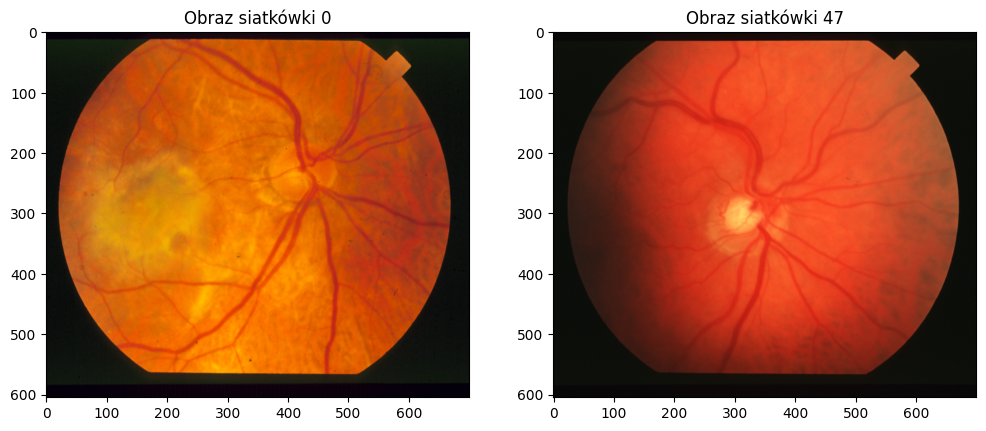

In [10]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

img1=Image.open(df["img"][0])
ax1.set_title("Obraz siatkówki 0")
ax1.imshow(img1)

rand=np.random.uniform(0,150)
img2=Image.open(df["img"][int(rand)])
ax2.set_title(f"Obraz siatkówki {int(rand)}")
ax2.imshow(img2)

plt.show()

W celu zobrazowania działania poszczególnych etapów przetwarzania obrazów siatkówki wszystkie oparacje beda przedstawiane na obrazie 0

# Proces przetwarzania obrazów

## Konwersja w skale szarości 

Każdy **piksel w obrazie kolorowym** składa sie z trzech składowych:

$
P_{(i,j)}=\begin{bmatrix} x & y & z \end{bmatrix}
\begin{bmatrix} 
R \\
G \\ 
B
\end{bmatrix}
$

aby przejść w **skale szarości** musimy z trzech wartości przejść do jednej:

$
P_{(i,j)gs} = 0.3 R + 0.6 G + 0.1 B
$



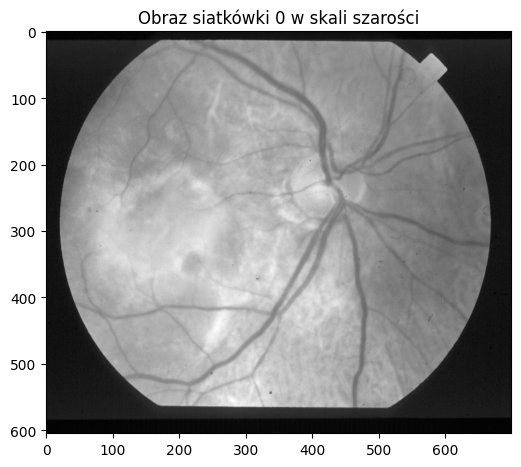

In [11]:
imgsGray = []
for i in range(len(df)):
    imgsGray.append(cv2.imread(df["img"][i],cv2.IMREAD_GRAYSCALE))

plt.figure(figsize=(6,6))
plt.title("Obraz siatkówki 0 w skali szarości")
plt.imshow(imgsGray[0],cmap="gray")
plt.show()

## Zwiekszenie kontrastu( Contrast-Limited Adaptive Histogram Equalization (CLAHE))

CLAHE zwiększa kontrast obrazu, stosując równanie histogramu do małych regionów (tiles) obrazu, jednocześnie ograniczając wzmacnianie szumu.

### 1. Podział obrazu na kafelki
   - Obraz $I$ jest dzielony na niepokrywające się kafelki o rozmiarze $t_x \times t_y $.

### 2. Obliczanie lokalnych histogramów
   - Dla każdego kafelka obliczany jest histogram intensywności $ h_k $.

### 3. Obcinanie histogramu
   - Wartości histogramu są ograniczane do maksymalnej wartości **clip limit**, aby uniknąć nadmiernego wzmocnienia szumów.  
   - Nadmiar wartości jest redystrybuowany między wszystkie przedziały histogramu.

<img src="imgs/cliplimit.png" alt="segment" title="SegemntLocal" width="784" height="300"/>


### 4. Równanie histogramu w kafelkach
   - Znormalizowany histogram jest przekształcany w skumulowaną funkcję rozkładu (CDF).  
   - Piksele są mapowane za pomocą CDF:

     $
     I_k'(x, y) = \lfloor (L - 1) \cdot P_k(I_k(x, y)) \rfloor
     $



### 5. Interpolacja między kafelkami(interpolacja dwuliniowa)

Interpolacja dwuliniowa to metoda stosowana do oszacowywania wartości punktu w siatce dwuwymiarowej(obrazie/macierzy), która bazuje na wartościach czterech sąsiednich punktów.

 - Interpolacja dwuliniowa zakłada, że wartość w punkcie wewnątrz siatki można przybliżyć jako liniową kombinację wartości w węzłach sąsiednich, zarówno w kierunku \(x\), jak i \(y\).


 - **Siatka i punkty**: Mamy siatkę punktów, a punktem, dla którego chcemy obliczyć wartość, jest \(P(x, y)\). Cztery najbliższe punkty w siatce mają współrzędne:
   - $Q_{11}(x_1, y_1)$
   - $Q_{21}(x_2, y_1)$
   - $Q_{12}(x_1, y_2)$
   - $Q_{22}(x_2, y_2)$

   Wartości w tych punktach to odpowiednio $f_{11}, f_{21}, f_{12}, f_{22}$.

   <img src="imgs/interpol.png" alt="segment" title="SegemntLocal" width="300" height="300"/>

 - **Interpolacja w kierunku $x$**:

   $
   f_{1}(x) = \frac{x_2 - x}{x_2 - x_1} f_{11} + \frac{x - x_1}{x_2 - x_1} f_{21}
   $

   $
   f_{2}(x) = \frac{x_2 - x}{x_2 - x_1} f_{12} + \frac{x - x_1}{x_2 - x_1} f_{22}
   $

   gdzie wartości $f_1$, $f_2$ odpowiadaja punktom $R_1$ , $R_2$ i sa interpolacja liniowa 

 - **Interpolacja w kierunku $y$**:

   $
   f(x, y) = \frac{y_2 - y}{y_2 - y_1} f_{1}(x) + \frac{y - y_1}{y_2 - y_1} f_{2}(x)
   $

   odpowiada interpolacji liniowej w kierunku y i korzysta z wartości $f_1$,$f_2$

 -  **Końcowy wzór**:
   Łącząc wszystkie kroki, otrzymujemy ostateczny wzór:

   $
   f(x, y) = \frac{1}{(x_2 - x_1)(y_2 - y_1)} \big[
   f_{11}(x_2 - x)(y_2 - y) + f_{21}(x - x_1)(y_2 - y) + 
   f_{12}(x_2 - x)(y - y_1) + f_{22}(x - x_1)(y - y_1)
   \big]
   $


### 6. Łączenie kafelków
   - Przetworzone kafelki są łączone w jeden, kontrastowy obraz.


CLAHE jest szczególnie przydatne w obrazowaniu medycznym, fotografii w słabym świetle oraz w innych scenariuszach wymagających adaptacyjnej korekcji kontrastu.

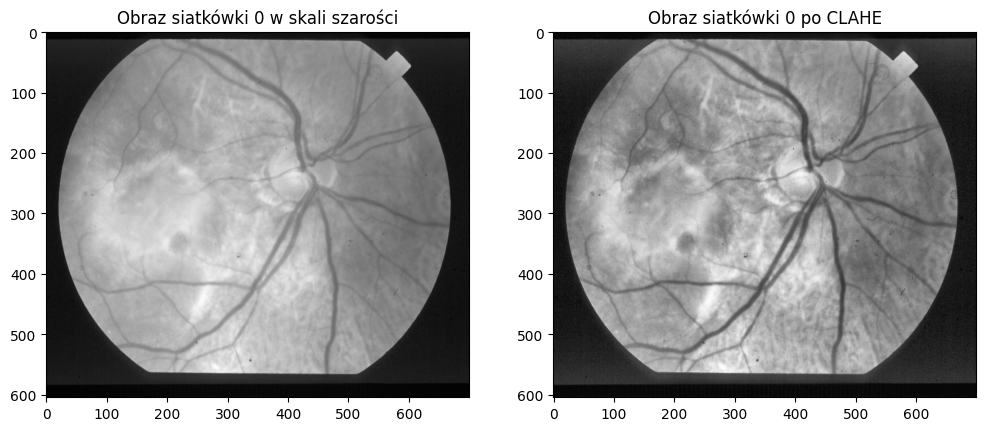

In [18]:
conImgs=[]
clahe = cv2.createCLAHE(clipLimit=1.5,tileGridSize=(8,8))
for i in range(len(df)):
    conImgs.append(clahe.apply(imgsGray[i]))

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.imshow(imgsGray[0],cmap="gray")
ax1.set_title("Obraz siatkówki 0 w skali szarości")

ax2.imshow(conImgs[0],cmap="gray")
ax2.set_title("Obraz siatkówki 0 po CLAHE")

plt.show()


## Gausowskie rozmycie (*Gaussian Blur*)

### Matematyczna Definicja:

Gaussian blur opiera się na funkcji rozkładu Gaussa, której wzór jest następujący:

$
G(x, y) = \frac{1}{2 \pi \sigma^2} \cdot \exp\left(-\frac{x^2 + y^2}{2 \sigma^2}\right)
$

Gdzie:
- $G(x, y)$ to wartość funkcji Gaussa w punkcie \( (x, y) \)
- $\sigma$ to odchylenie standardowe, które kontroluje "rozmycie" (większe $ \sigma$ oznacza silniejsze rozmycie)
- $ x $ i $ y $ to współrzędne punktu względem środka filtra

**Proces wygładzania** obrazu polega na **konwolucji** obrazu z filtrem Gaussa. Oznacza to, że dla każdego piksela w obrazie oblicza się średnią ważoną z pikseli wokół niego, gdzie wagi są zależne od funkcji Gaussa.

Formuła dla konwolucji obrazu $I$ z filtrem Gaussa wygląda następująco:

$
I_{\text{blurred}}(x, y) = \sum_{i=-k}^{k} \sum_{j=-k}^{k} I(x+i, y+j) \cdot G(i, j)
$

Gdzie:
- $I(x, y)$ to wartość piksela w oryginalnym obrazie
- $G(i, j)$ to wartość wagi z funkcji Gaussa
- $k$ to promień okna filtra (zwykle rozmiar filtra to $(2k+1) \times (2k+1)$ w naszym przykładzie $k=1$ wiec filtr to macierz $3 \times 3$)

Filtr Gaussa  $3 \times 3$  dla  $\sigma = 1$ :


\begin{bmatrix}
0.0751 & 0.1238 & 0.0751 \\
0.1238 & 0.2042 & 0.1238 \\
0.0751 & 0.1238 & 0.0751
\end{bmatrix}

**Proces wygładzania** zwizualizowany poniżej obrazuje działanie matematycznych założeń filtra gausa na przykładzie małego obrazu, wartosci z macierzy filtra zostały zaokraglone do dwóch miejsc po przecinku




<img src="imgs/blurrgif.gif" alt="segment" title="SegemntLocal" width="900" height="450"/>

**Wizualizacja** filtru gaussa obrazująca rozkład wag

<img src="imgs/gausskernel3d.png" alt="segment" title="SegemntLocal" width="900" height="450"/>

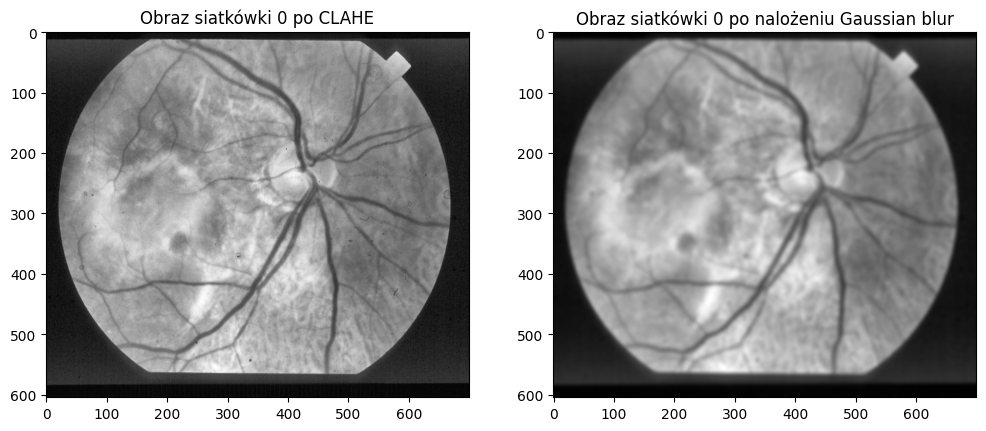

In [19]:
blurredImgs=[]
for i in range(len(df)):
    blurredImgs.append(cv2.GaussianBlur(conImgs[i],(11,11),3))

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.imshow(conImgs[0],cmap="gray")
ax1.set_title("Obraz siatkówki 0 po CLAHE")

ax2.imshow(blurredImgs[0],cmap="gray")
ax2.set_title("Obraz siatkówki 0 po nalożeniu Gaussian blur")

plt.show()


## Wykrywanie krawędzi(algorytm Canny)

### 1. Gradienty

#### a) Obliczenie gradientów $G_x$ i $G_y$
Gradient obrazu mierzy zmianę jasności pikseli. Wykorzystuje się **operator Sobela**, aby obliczyć gradient w kierunkach poziomym $(x)$ i pionowym $(y)$. Gradienty w kierunku poziomym i pionowym są obliczane za pomocą splotu obrazu $I(x, y)$ z maskami Sobela:

- **Maski Sobela**:
  $
  S_x = \begin{bmatrix}
  -1 & 0 & 1 \\
  -2 & 0 & 2 \\
  -1 & 0 & 1
  \end{bmatrix}, \quad
  S_y = \begin{bmatrix}
  -1 & -2 & -1 \\
   0 &  0 &  0 \\
   1 &  2 &  1
  \end{bmatrix}
  $

- **Splot obrazu**:
  $
  G_x = I(x, y) * S_x, \quad G_y = I(x, y) * S_y
  $

#### b) Wielkość gradientu $G$
Wielkość gradientu określa intensywność zmiany jasności:

$
G = \sqrt{G_x^2 + G_y^2}
$

#### c) Kierunek gradientu $\theta$
Kierunek gradientu wskazuje orientację krawędzi:
$
\theta = \arctan\left(\frac{G_y}{G_x}\right)
$

Aby uprościć obliczenia, kierunek gradientu $\theta$ jest zaokrąglany do jednej z czterech orientacji:
- $0^\circ $ poziomo 
- $45^\circ$ 
- $90^\circ$ pionowo 
- $135^\circ$ 

---

### 3. Niejednoznaczne tłumienie (*Non-Maximum Suppression*)

Celem tego kroku jest usunięcie pikseli, które nie są lokalnymi maksimami gradientu, aby uzyskać bardziej wyraźne krawędzie.

#### a) Porównanie gradientu z sąsiadami
Dla każdego piksela $(x, y)$:
1. Wyznacz kierunek gradientu (zaokrąglony do jednej z 4 orientacji).
2. Porównaj wartość gradientu $G(x, y)$ z wartością gradientu sąsiadów **w kierunku gradientu**:
   - Jeśli $\theta \approx 0^\circ$: Porównanie z pikselami w osi $x$.
   - Jeśli $\theta \approx 45^\circ$: Porównanie z pikselami po przekątnej (lewy górny i prawy dolny)
   - Jeśli $\theta \approx 90^\circ$: Porównanie z pikselami w osi $y$.
   - Jeśli $\theta \approx 135^\circ$: Porównanie z pikselami po przekątnej (lewy dolny i prawy górny)

Kierunki przypisane do danych kątów wydaja się nieintuicyjne wynika to z przeciwnego skierowania osi $Y$, w obrazach początek układu wspołrzednych 

#### b) Eliminacja pikseli
Jeśli wartość gradientu $G(x, y)$ nie jest większa od sąsiadów w kierunku gradientu, wartość $G(x, y)$ jest ustawiana na $0$:

$
G'(x, y) =
\begin{cases}
G(x, y), & \text{jeśli } G(x, y) > G(x_1, y_1) \text{ i } G(x, y) > G(x_2, y_2) \\
0, & \text{w przeciwnym razie.}
\end{cases}
$

---

### 4. Podwójne progowanie (*Double Thresholding*)
Celem progowania jest okreslenie czy dany piksel jest istotny czy nie 

#### a) Klasyfikacja pikseli
Każdy piksel jest klasyfikowany na podstawie wartości gradientu $G'(x, y)$ i porównywany z narzuconymi wartościami tolerancji:
- **Silne krawędzie**: $G'(x, y) > T_{\text{high}}$
- **Słabe krawędzie**: $T_{\text{low}} < G'(x, y) \leq T_{\text{high}}$
- **Inne piksele**: $G'(x, y) \leq T_{\text{low}}$

#### b) Efekt progowania
- Silne krawędzie są bezpośrednio uwzględniane.
- Słabe krawędzie są uwzględniane tylko, jeśli sąsiadują z silnymi krawędziami.
- Inne piksele są ignorowane.

---

### 5. Histereza (*Edge Tracking by Hysteresis*)

#### a) Łączenie krawędzi
- Słabe piksele są iteracyjnie sprawdzane:
  - Jeśli słaby piksel sąsiaduje z silnym pikselem, zostaje oznaczony jako krawędź.
  - W przeciwnym razie jest ignorowany.

$
E(x, y) =
\begin{cases}
1, & \text{jeśli piksel należy do silnej krawędzi lub łączy się z nią} \\
0, & \text{w przeciwnym razie.}
\end{cases}
$


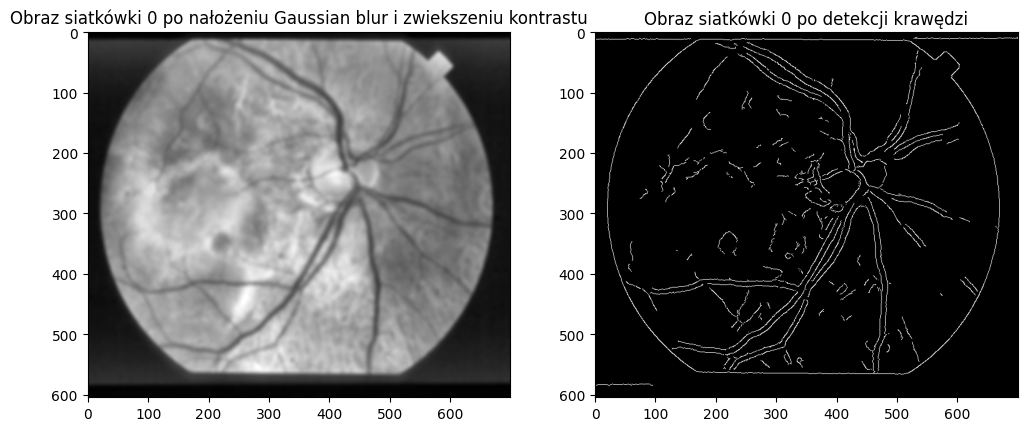

In [37]:
edgeImgs=[]
for i in range(len(df)):
    edgeImgs.append(cv2.Canny(blurredImgs[i],25,45))

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.imshow(blurredImgs[0],cmap="gray")
ax1.set_title("Obraz siatkówki 0 po nałożeniu Gaussian blur i zwiekszeniu kontrastu")

ax2.imshow(edgeImgs[0],cmap="gray")
ax2.set_title("Obraz siatkówki 0 po detekcji krawędzi")

plt.show()

## Współczynnik korelacji

**Współczynnik korelacji** to miara zależności liniowej między dwiema zmiennymi. Określa, jak silnie i w jakim kierunku dwie zmienne są ze sobą powiązane.

---

Dla dwóch zmiennych $X$ i $Y$, współczynnik korelacji jest wyznaczany wzorem:

$
r = \frac{\text{Cov}(X, Y)}{\sigma_X \cdot \sigma_Y}
$

Gdzie:  
- $ \text{Cov}(X, Y) $: kowariancja zmiennych $X$ i $Y$, obliczana jako:  

  $
  \text{Cov}(X, Y) = \frac{1}{n} \sum_{i=1}^n (X_i - \mu_X)(Y_i - \mu_Y)
  $

  $\mu_X$ i $\mu_Y$ to średnie wartości $X$ i $Y$, a $n$ to liczba obserwacji.

- $\sigma_X$: odchylenie standardowe zmiennej $ X $:  

  $
  \sigma_X = \sqrt{\frac{1}{n} \sum_{i=1}^n (X_i - \mu_X)^2}
  $

- $\sigma_Y$: odchylenie standardowe zmiennej $Y$ liczone w taki sam sposób jak $X$.

**Wartości współczynnika**

- $ r = 1 $: idealna dodatnia zależność liniowa (gdy $X $ rośnie, $Y $ rośnie proporcjonalnie).
- $r = -1 $: idealna ujemna zależność liniowa (gdy $X$ rośnie, $Y $ maleje proporcjonalnie).
- $r = 0 $: brak zależności liniowej (mogą istnieć inne rodzaje zależności, np. nieliniowe).

Wartości $r$ zawsze znajdują się w zakresie $[-1, 1]$.

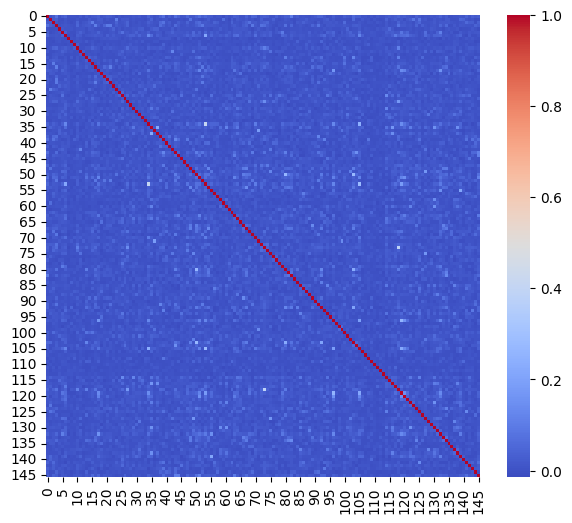

In [21]:
flatEdgeImgs = [img.flatten() for img in edgeImgs]

corrMatrix= np.corrcoef(flatEdgeImgs)

plt.figure(figsize=(7,6))
sns.heatmap(corrMatrix,annot=False,cmap="coolwarm",cbar=True)
plt.show()

0.4082188439106085


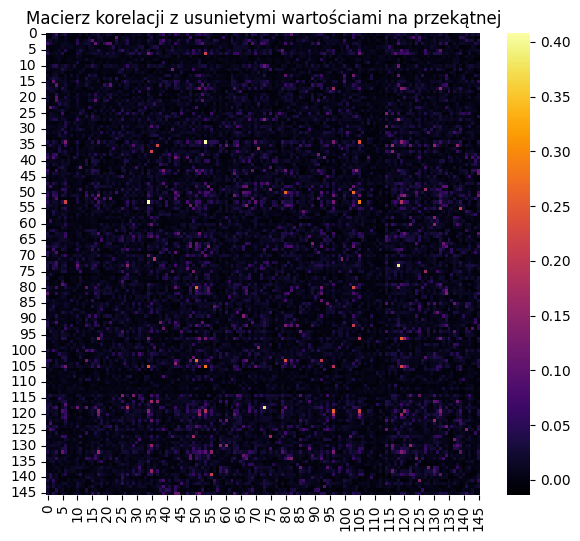

In [22]:

corrMatrix[corrMatrix == 1] = 0
corrMatrix[corrMatrix == 0.9999999999999999] = 0
corrMatrix[corrMatrix == 0.9999999999999998] = 0

print(np.max(corrMatrix))

plt.figure(figsize=(7,6))
sns.heatmap(corrMatrix,annot=False,cmap="inferno",cbar=True)
plt.title("Macierz korelacji z usunietymi wartościami na przekątnej")
plt.show()

Z macierzy bez wartości na przekątnych możemy znaleźć przypadki dla których wspołczynnik korelacji przekroczył oczekiwany próg 

34
53


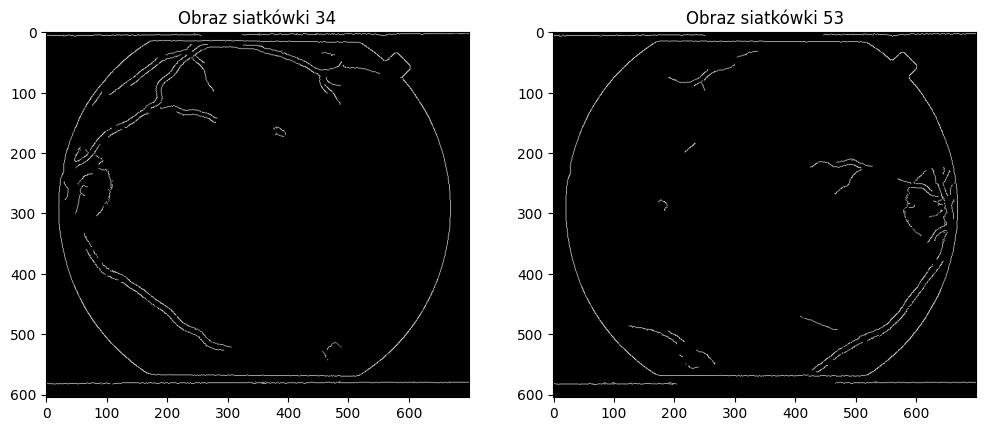

In [38]:
pos=np.where(corrMatrix == 0.4082188439106085)
row , col = pos[0][0], pos[0][1]

print(row)
print(col)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.imshow(edgeImgs[int(row)],cmap="gray")
ax1.set_title("Obraz siatkówki 34")

ax2.imshow(edgeImgs[int(col)],cmap="gray")
ax2.set_title("Obraz siatkówki 53")

plt.show()

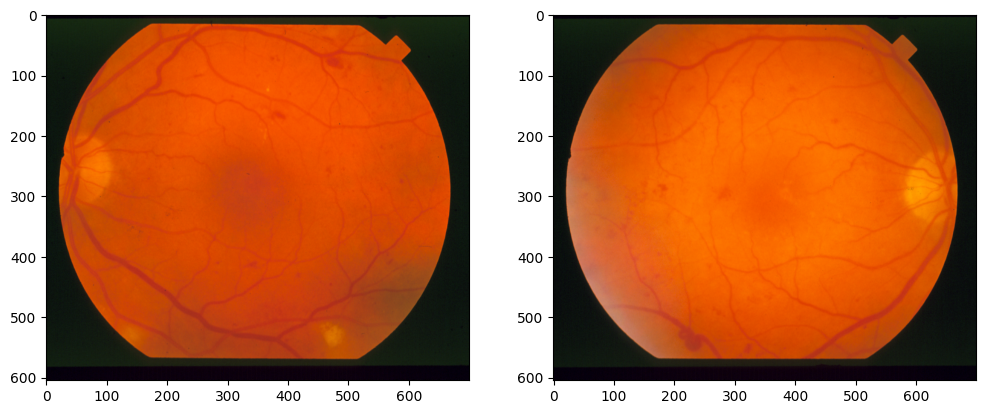

In [28]:
ig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

img1=Image.open(df["img"][int(row)])
ax1.imshow(img1)

img2=Image.open(df["img"][int(col)])
ax2.imshow(img2)

plt.show()


## Wnioski 

Na podstawie macierzy korelacji można sformułować kilka kluczowych wniosków:  
   W macierzy z usuniętymi wartościami korelacji obrazów samych ze sobą widać, że maksymalna wartość korelacji między dwoma różnymi obrazami wynosi około 0.4 co wskazuje na ograniczone podobinestow czyli niektore cechy wystepuja na obu obrazach np. któaś z krawędzi pokrywa się na tych dwóch obrazach. Wskazuje to na umiarkowane podobieństwo, ale jednocześnie podkreśla różnorodność analizowanych obrazów. Wyniki sugerują, że każde zdjęcie siatkówki jest dość unikalne, co potwierdza teze o unikalności siatkówki każdego człowieka.

---

## Wady i pominięte aspekty podejścia

**Brak porównania obrazów tej samej osoby**:  Z uwagi na przyjęte podejście i dostępne dane, nie było możliwości sprawdzenia, jak dobrze metoda działa w przypadku porównywania różnych zdjęć siatkówki tego samego człowieka. Obrazy takie pomimo przedstawiania siatkówki jednego czlowieka ze wzgeledu na warunki wykonania zdjecai mogą różnić się pod względem jakości, rotacji, oświetlenia i ilości szumu co mogło wpłynąć na uzyskane wartości korelacji. Wprowadzenie normalizacji tych czynników mogłoby poprawić wyniki. Takie porównania mogłyby lepiej zweryfikować efektywność algorytmu w rzeczywistych zastosowaniach.

---

Podsumowując, wykorzystane metody przetwarzania sygnałów spełniły sowje zadanie i pokazały ze kazdy człowiek ma unikalną siatkówke aczkolwiek, nie byłaby skuteczna w identyfikacji obrazów ze wzgledu na zbyt wiele czynników zewnetrznych wpływających na poziom szumu i intensywnosć obrazu. Aby skutecznie identyfikowac ludzi na podstawie róznych obrazów siatkówki należałoby zastosować dokładniejsze metody analizy obrazów.



#### Dataset

- https://www.kaggle.com/datasets/vidheeshnacode/stare-dataset

#### źródła

- https://github.com/abhilas0/edge_detection/blob/master/edge_detection.ipynb
- https://pub.towardsai.net/gaussian-blurring-a-gentle-introduction-e34aca1d9bbd
- https://pub.towardsai.net/image-gradient-sobel-operator-ddfe253b49b1
- https://theailearner.com/tag/cdf/
- https://cecas.clemson.edu/~ahoover/stare/
- https://slideplayer.pl/slide/5628322/ 

